In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import nibabel as nib
from utils import utils

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
model = load_model('D:/Study/Thesis/LiTS/models/liver_weights_best.h5')

In [4]:
file_path = 'D:/Study/Thesis/LiTS/volume-130.nii'

In [5]:
image_arr = utils.nifti_to_array(file_path=file_path)

In [6]:
with tf.device('/device:GPU:1'):
    pred = model.predict(image_arr, verbose = 1, batch_size=4)
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

156/156 [==============================] - 823s 5s/step


In [7]:
liver_seg = pred[:,:,:,0]

In [8]:
(x, y, z) = liver_seg.shape
kernel1 =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5))
kernel2 =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5))
for i in range(x):
    axial = cv2.morphologyEx(liver_seg[i,:,:], cv2.MORPH_CLOSE, kernel1)
    liver_seg[i,:,:] = cv2.morphologyEx(axial, cv2.MORPH_OPEN, kernel2)
for i in range(y):
    coronal = cv2.morphologyEx(liver_seg[:,i,:], cv2.MORPH_CLOSE, kernel1)
    liver_seg[:,i,:] = cv2.morphologyEx(coronal, cv2.MORPH_OPEN, kernel2)
for i in range(z):
    sagittal = cv2.morphologyEx(liver_seg[:,:,i], cv2.MORPH_CLOSE, kernel1)
    liver_seg[:,:,i] = cv2.morphologyEx(sagittal, cv2.MORPH_OPEN, kernel2)


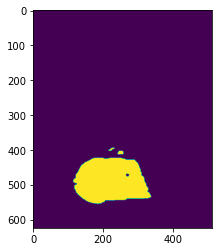

In [9]:
plt.imshow(liver_seg[:,300,:])

In [10]:
output_dir = "D:/Study/Thesis/LiTS/test"
origin_volume = nib.load(file_path)
(d, w, h) = liver_seg.shape
seg_vol = np.zeros(origin_volume.shape).astype('uint8')
for i in range(d):
    seg_vol[:,:,i] = np.fliplr(np.transpose(liver_seg[i]))
new_img = nib.Nifti1Image(seg_vol, origin_volume.affine, origin_volume.header)
nib.save(new_img, os.path.join(output_dir, 'segmentation-130.nii'))


In [11]:
tumor_model = load_model('D:/Study/Thesis/LiTS/models/tumor-liver-crops-512x512_weights_best.h5')
tumor_polar_model = load_model('D:/Study/Thesis/LiTS/models/tumor-liver-crops-polar-512x512_weights_best.h5')

In [12]:
def to_cart(input_img, center):
  #input_img = input_img.astype(np.float32)
  input_img = cv2.rotate(input_img, cv2.ROTATE_90_CLOCKWISE)
  value = np.sqrt(((input_img.shape[1]/2.0)**2.0)+((input_img.shape[0]/2.0)**2.0))
  polar_image = cv2.linearPolar(input_img, center, value, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
  #polar_image = polar_image.astype(np.uint8)
  return polar_image

In [13]:
liver_seg.max()

1.0

Applying Connected Component and take components with num pixels > max_pixels
Found  5 labels
1 : 478
2 : 4661451
3 : 768
4 : 7778
5 : 248
Max CC label is:  0
Num liver before CC:  4670723
Num liver After CC:  4661451
1/1 [==============================] - 3s 3s/step


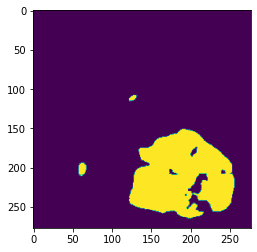

In [14]:
seg_liver_CC = utils.get_CC_largerThanTh(np.where(liver_seg > 0, 1, 0), dbg=False)

# 3-D Crop coordinates
(h1, h2, w1, w2) = utils.get_crop_coordinates_3D(seg_liver_CC, dbg=False)
liver_crop_w, liver_crop_h = (512, 512)
curr_liver_crop_w, curr_liver_crop_h = liver_seg[500, h1:h2, w1:w2].shape
crop_img = cv2.resize(image_arr[500, h1:h2, w1:w2,:], (liver_crop_w, liver_crop_h), interpolation=cv2.INTER_CUBIC)
crop_img = np.expand_dims(crop_img, axis=0)
pred_tumor = tumor_model.predict(crop_img, verbose=1)[0][:,:,0]
if pred_tumor.sum() != 0:
    center = utils.centroid(pred_tumor)
    crop_img = utils.to_polar(crop_img[0], center)
    crop_img = np.expand_dims(crop_img, axis=0)
    pred_tumor = tumor_polar_model.predict(crop_img, verbose = 1)[0][:,:,0]
    pred_tumor = to_cart(pred_tumor, center)
pred_tumor = cv2.resize(pred_tumor, (curr_liver_crop_w, curr_liver_crop_h), interpolation=cv2.INTER_NEAREST)
plt.imshow(pred_tumor)

In [15]:
pred_tumor.max()

0.9999974

In [16]:
filename = 'segmentation-130.nii'
seg_liver_CC = utils.get_CC_largerThanTh(np.where(liver_seg > 0, 1, 0), dbg=False)

# 3-D Crop coordinates
(h1, h2, w1, w2) = utils.get_crop_coordinates_3D(seg_liver_CC, dbg=False)
seg_lesion_arr = np.zeros((d, w, h)).astype('uint8')
# Crop in 3D
crop_img_arr = image_arr[:, h1:h2, w1:w2, :]
crop_mask_arr = liver_seg[:, h1:h2, w1:w2]
liver_crop_w, liver_crop_h = (512, 512)
_, curr_liver_crop_w, curr_liver_crop_h = crop_mask_arr.shape
for i in range(d):
    if crop_mask_arr[i].sum() == 0:
        pred_tumor = np.zeros((liver_crop_w, liver_crop_h)).astype('uint8')
    else:
        crop_img = cv2.resize(crop_img_arr[i], (liver_crop_w, liver_crop_h), interpolation=cv2.INTER_CUBIC)
        crop_img = np.expand_dims(crop_img, axis=0)
        pred_tumor = tumor_model.predict(crop_img, verbose=1)[0][:,:,0].astype('uint8')
        pred_tumor[pred_tumor >= 0.5] = 1
        pred_tumor[pred_tumor < 0.5] = 0
        if pred_tumor.sum() != 0:
            center = utils.centroid(pred_tumor)
            crop_img = utils.to_polar(crop_img[0], center)
            crop_img = np.expand_dims(crop_img, axis=0)
            pred_tumor = tumor_polar_model.predict(crop_img, verbose = 1)[0][:,:,0]
            pred_tumor[pred_tumor > 0.2] = 1
            pred_tumor[pred_tumor < 0.2] = 0
            pred_tumor = to_cart(pred_tumor, center)

    pred_tumor = cv2.resize(pred_tumor, (curr_liver_crop_w, curr_liver_crop_h), interpolation=cv2.INTER_NEAREST)
    pred_tumor[crop_mask_arr[i] == 0] = 0
    seg_lesion_arr[i, h1:h2, w1:w2] = pred_tumor

seg_lesion_arr[seg_lesion_arr == 1] = 2

  
seg_lesion_arr.max()


Applying Connected Component and take components with num pixels > max_pixels
Found  5 labels
1 : 478
2 : 4661451
3 : 768
4 : 7778
5 : 248
Max CC label is:  0
Num liver before CC:  4670723
Num liver After CC:  4661451
1/1 [==============================] - 1s 1s/step


2

In [17]:
seg_tumor = np.zeros(origin_volume.shape).astype('uint8')
for i in range(d):
    seg_tumor[:,:,i] = np.fliplr(np.transpose(seg_lesion_arr[i]))
seg_tumor = nib.Nifti1Image(seg_tumor, origin_volume.affine, origin_volume.header)
nib.save(seg_tumor, os.path.join(output_dir, 'polar-segmentation-130.nii'))     